### This notebook trains a model to detect if a given image is healthy or diseased. The diseased images would be further classified by another model. This approach performed very poorly.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.basic_train import *
from fastai.vision.learner import *
import pandas as pd
import numpy as np
import cv2

from efficientnet_pytorch import EfficientNet

In [3]:
df = pd.read_csv('../Data/Old_data/UnimodalLabels.csv').fillna('')#.iloc[:100,:]

In [4]:
df.head()

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ac43687b8>]], dtype=object)

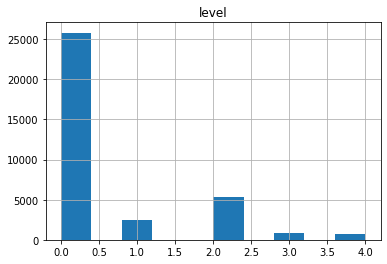

In [5]:
df.hist()

In [6]:
df.level = df.level.apply(lambda x: 0 if x!=0 else 1)

In [7]:
old_stats = ([0.7229, 0.6502, 0.6050], [0.1622, 0.1431, 0.1128])
def get_data(size=224,bs=32):
    np.random.seed(420)
    
    tfms = [[rotate(degrees=(-5,5),p=0.5),
         flip_lr(p=0.5),
         contrast(scale=(0.7,1),p=0.5)],[]]
    tfms[0].extend(rand_resize_crop(size,max_scale=2))
    
    data = (ImageList.from_df(df,'../Data/Old_data/train_processed')
    .split_by_rand_pct(valid_pct=0.1)
    .label_from_df(cols='level')
    .transform(tfms, size=size)
    .databunch(bs=bs)).normalize(old_stats)
# #         ds_tfms=tfms,
# #         size=size,
# #         bs = bs,
# #         label_delim = ',',
# #         valid_pct = 0.1,
# #         num_workers = os.cpu_count() 
#     )#.normalize(old_stats)
    
    return data

In [8]:
# learn = cnn_learner(get_data(448,16),models.resnet18,
#                     callback_fns=[ShowGraph,
#                               partial(SaveModelCallback, every='epoch', name='epoch'),
#                               partial(SaveModelCallback, every='improvement', monitor='accuracy', name='1_best_acc', mode='max')],
#                     metrics = [accuracy],
#                     loss_func = FocalLoss()
#                    )

model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)#.cuda()
learn = Learner(get_data(448,16),
                model,
                wd=1e-5,
                callback_fns=[ShowGraph,
                              partial(SaveModelCallback, every='epoch', name='epoch'),
                              partial(SaveModelCallback, every='improvement', monitor='accuracy', name='1_best_acc', mode='max'),
                              partial(AccumulateScheduler, n_step=2),
#                               partial(ReduceLROnPlateauCallback, patience=2, min_delta=2e-3, factor=0.2, monitor='multi_kappa_score', mode='max')
                             ],
                loss_func = CrossEntropyFlat(reduction='sum'),
                metrics=[accuracy]
               )

# learn.to_fp16()
# learn.mixup(alpha=0.05)
learn.unfreeze()
learn.load('1_best_acc')

Loaded pretrained weights for efficientnet-b0


Learner(data=ImageDataBunch;

Train: LabelList (31598 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
1,1,1,0,0
Path: ../Data/Old_data/train_processed;

Valid: LabelList (3510 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
1,1,0,0,1
Path: ../Data/Old_data/train_processed;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    

In [6]:
def do_fit(learner, epochs, lr, start_epoch=0, name='B4_Class', res=224, bs=16, div=25):
#     learner.data = get_data(size=res,bs=bs)
#     learner.to_fp16()
#     learner.mixup(stack_y=False)
    learner.fit_one_cycle(epochs, lr, pct_start=0.3, div_factor=div, start_epoch=start_epoch)
    learner.save(name+'_'+str(res)+'_'+str(start_epoch+epochs))
    print('Model saved as '+name+'_'+str(res)+'_'+str(start_epoch+epochs))

epoch,train_loss,valid_loss,accuracy,time
0,8.382846,8.400024,0.753846,18:25


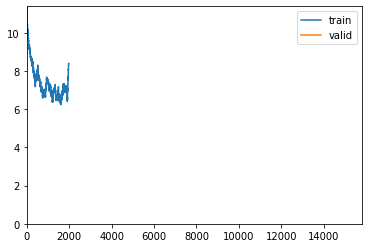

Better model found at epoch 0 with accuracy value: 0.7538461685180664.


/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.ReduceLROnPlateauCallback'> conditioned on metric `multi_kappa_score` which is not available. Available metrics are: train_loss, valid_loss, accuracy
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')


In [ ]:
do_fit(learn, 8, 3e-3, res=448, bs=16)

Loaded epoch_0
Model 1_best_acc_0 not found.


epoch,train_loss,valid_loss,accuracy,time
1,7.168463,8.250401,0.791738,18:13
2,7.279513,6.469116,0.847293,18:14
3,6.376612,6.309404,0.847578,18:14
4,6.362529,6.340978,0.843020,18:15
5,5.683250,5.110939,0.883191,18:15
6,5.486892,4.997781,0.884900,18:18
7,5.234699,4.954198,0.886325,18:14


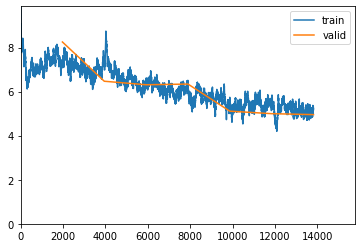

Better model found at epoch 1 with accuracy value: 0.7917379140853882.
Better model found at epoch 2 with accuracy value: 0.8472934365272522.
Better model found at epoch 3 with accuracy value: 0.8475783467292786.
Better model found at epoch 5 with accuracy value: 0.8831908702850342.
Better model found at epoch 6 with accuracy value: 0.8849002718925476.
Better model found at epoch 7 with accuracy value: 0.8863247632980347.
Model saved as B4_Class_448_9


In [8]:
do_fit(learn, 8, 3e-3, res=448, bs=16, start_epoch=1)

In [9]:
df = pd.read_csv('../Data/train_labels.csv')
df.diagnosis =  df.diagnosis.apply(lambda x: 0 if x!=0 else 1)
def get_data(size=224,bs=32):
    np.random.seed(420)
    tfms = [[rotate(degrees=(-5,5),p=0.5),
         flip_lr(p=0.5),
         contrast(scale=(0.7,1),p=0.5)],[]]
    tfms[0].extend(rand_resize_crop(size,max_scale=2))

    data = (ImageList.from_df(df,'../Data/train_processed')
    .split_by_rand_pct(valid_pct=0.1)
    .label_from_df(cols='diagnosis')
    .transform(tfms, size=size)
    .databunch(bs=bs)).normalize(old_stats)
    return data
learn.data = get_data(448,16)
learn.to_fp16()

# do_fit(learn, 10, 2e-5, res=448, bs=16)                                                        

Learner(data=ImageDataBunch;

Train: LabelList (3296 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
0,0,0,1,1
Path: ../Data/train_processed;

Valid: LabelList (366 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
0,0,0,0,0
Path: ../Data/train_processed;

Test: None, model=EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): Ba

In [10]:
learn.validate()

[1.3922176, tensor(0.9836)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f40c174ab70>]], dtype=object)

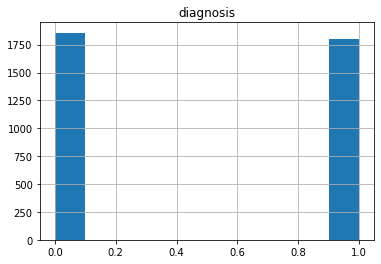

In [11]:
df.hist()

In [32]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
!sudo shutdown -h 1

In [ ]:
!sudo shutdown -c

In [15]:
gc.collect()

169

In [10]:
# os.mkdir('../dump/classifier')
learn.path=Path('../dump2/classifier')
learn.export()